In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import csv
import pandas as pd
from scipy import stats
import re
from scipy.stats.stats import pearsonr
#import rpy2.robjects as robjects
import random
from statsmodels.stats.multitest import fdrcorrection
import copy
from collections import Counter
import seaborn as sns

palette = {"Human":"#E31A1C", 
           "Chimp":"#1F78B4",
          "Rhesus":"#6A3D9A",
          "Orangutan":"#FF7F00",
          "Marmoset":"#FFFF99",
          "Gorilla":"#A6CEE3",
          "Mouse":"#CAB2D6",
          "Bonobo":"#B15928",
          "human":"#E31A1C", 
           "chimp":"#1F78B4",
          "rhesus":"#6A3D9A",
          "orangutan":"#FF7F00",
          "marmoset":"#FFFF99",
          "gorilla":"#A6CEE3",
          "mouse":"#CAB2D6",
          "bonobo":"#B15928",
          "Human_ctrl":"#E31A1C",
          "Human_aut":"black"}


C:\Users\astar\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
C:\Users\astar\AppData\Local\Temp\ipykernel_24752\3968340371.py:8: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


13534


In [4]:
#This is specifically for plotting for the cell type proportions paper
hum_chp = pd.read_csv("Subclass/Processed/DESeq2_L2-3_IT_Human_Chimp_cpm.txt", sep = "\t")
hum_gor = pd.read_csv("Subclass/Processed/DESeq2_L2-3_IT_Human_Gorilla_cpm.txt", sep = "\t")
hum_rhe = pd.read_csv("Subclass/Processed/DESeq2_L2-3_IT_Human_Rhesus_cpm.txt", sep = "\t")
hum_marm = pd.read_csv("Subclass/Processed/DESeq2_L2-3_IT_Human_Marmoset_cpm.txt", sep = "\t")
keep_genes = np.intersect1d(hum_chp.index, hum_gor.index)
keep_genes = np.intersect1d(keep_genes, hum_rhe.index)
keep_genes = np.intersect1d(keep_genes, hum_marm.index)
print(len(keep_genes))

def read_file(file, output, gene, t, species = "PTB", h = False):
    tpm = pd.read_csv(file, sep = "\t")
    tpm = tpm.loc[np.intersect1d(keep_genes, tpm.index)]
    for i in tpm.columns:
        tpm[i] = tpm[i]*(1000000/np.sum(tpm[i]))
    tpm_gene = tpm.loc[gene]
    if h:
        for index in tpm_gene.index:
            if "Human" in index:
                output.append([tpm_gene[index], "Human", t])
            elif "Chimp" in index or species.lower() in index:
                output.append([tpm_gene[index], "Chimp", t])
            elif "Rhesus" in index:
                output.append([tpm_gene[index], "Rhesus", t])
            elif "Marmoset" in index:
                output.append([tpm_gene[index], "Marmoset", t])
    else:
        for index in tpm_gene.index:
            if "Rhesus" in index:
                output.append([tpm_gene[index], "Rhesus", t])
            elif "Marmoset" in index:
                output.append([tpm_gene[index], "Marmoset", t])
            elif "Gorilla" in index:
                output.append([tpm_gene[index], "Gorilla", t])
    return output

def read_de(file, gene, output, comp):
    de = pd.read_csv(file, sep = "\t")
    de = de.set_index("Gene")
    de_gene = de.loc[gene]
    output.append([comp, round(float(de_gene["log2FoldChange"]), 5), float(de_gene["pvalue"]), float(de_gene["padj_mine"])])
    return output

13534


In [7]:
celltypes = ['Sst', 'Sst Chodl', 'OPC', 'Micro-PVM', 'L6 CT', 'Lamp5_Lhx6', 'Chandelier', 'Pvalb', 'L4 IT', 'VLMC', 'L2/3 IT', 'Pax6', 'Endo', 'Vip', 'Astro', 'L5 IT', 'L5/6 NP', 'Lamp5', 'Sncg', 'L5 ET', 'Oligo', 'L6 IT Car3', 'L6 IT', 'L6b']
celltypes = [x.replace(" ", "_").replace("/", "-") for x in celltypes]


def plot_AllenMTG2023_tpm(gene, celltypes = celltypes, CPM = True, species = ["Human", "Chimp", "Gorilla", "Rhesus", "Marmoset"]):
    folder = "Subclass/Processed/"
    output = []
    if CPM:
        skel = "DESeq2_REPLACE_Human_Chimp_cpm.txt"
    else:
        skel = "DESeq2_REPLACE_Human_Chimp_tpm.txt"
    for t in celltypes:
        file = folder + "/" + skel.replace("REPLACE", t)
        output = read_file(file, output, gene, t, h = True)
    
    if CPM:
        skel = "DESeq2_REPLACE_Human_Gorilla_cpm.txt"
    else:
        skel = "DESeq2_REPLACE_Human_Gorilla_tpm.txt"
    for t in celltypes:
        file = folder + "/" + skel.replace("REPLACE", t)
        output = read_file(file, output, gene, t, h = False)

    if CPM:
        skel = "DESeq2_REPLACE_Human_Rhesus_cpm.txt"
    else:
        skel = "DESeq2_REPLACE_Human_Rhesus_tpm.txt"
    for t in celltypes:
        file = folder + "/" + skel.replace("REPLACE", t)
        output = read_file(file, output, gene, t, species = "Rhesus", h = False)
        
    if CPM:
        skel = "DESeq2_REPLACE_Human_Marmoset_cpm.txt"
    else:
        skel = "DESeq2_REPLACE_Human_Marmoset_tpm.txt"
    for t in celltypes:
        file = folder + "/" + skel.replace("REPLACE", t)
        output = read_file(file, output, gene, t, species = "Marmoset", h = False)
    df = pd.DataFrame(output)
    
    if CPM:
        df.columns = ["CPM", "Species", "Cell Type"]
        fig, ax = plt.subplots(figsize=(18,6))
        ax = sns.swarmplot(x="Cell Type", y="CPM", hue = "Species", data=df, dodge = True, order = celltypes, palette = palette)
        ax = sns.boxplot(x="Cell Type", y="CPM", hue = "Species", data=df, boxprops={'facecolor':'None'}, showfliers=False, order = celltypes)
    else:
        df.columns = ["TPM", "Species", "Cell Type"]
        fig, ax = plt.subplots(figsize=(18,6))
        ax = sns.swarmplot(x="Cell Type", y="TPM", hue = "Species", data=df, dodge = True, order = celltypes, palette = palette)
        ax = sns.boxplot(x="Cell Type", y="TPM", hue = "Species", data=df, boxprops={'facecolor':'None'}, showfliers=False, order = celltypes)
    
    plt.legend([],[], frameon=False)
    ax.set_xlabel("Cell Type")
    ax.set_title("Expression of " + gene)
    plt.xticks(rotation=45, ha = "right")
    plt.show()
    return ax, df

ax, v = plot_AllenMTG2023_tpm("DLG4", celltypes = ["L2-3_IT"])

KeyError: 'GRIN2A'

0.0
1.0
2.0
3.0
4.0


Text(0.5, 1.0, 'Expression of $\\it{BAZ1B}$ in MTG L2/3 IT neurons')

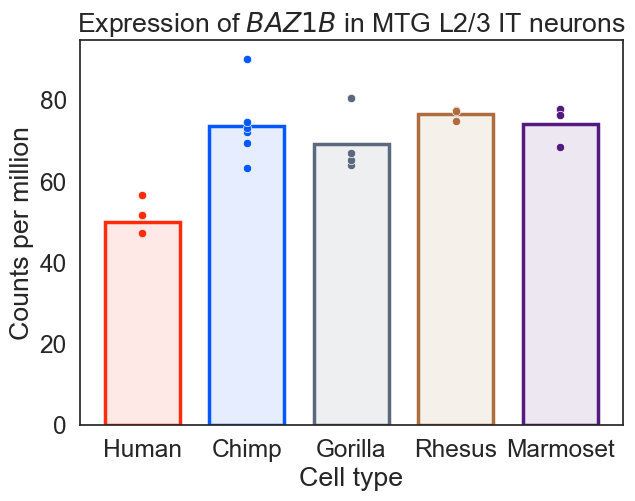

In [47]:
#To plot across all species

new_palette = {"Human":"#FF2C0C", "Chimp":"#0058FF", "Rhesus":"#AD6D3E", "Marmoset":"#551A7F", "Gorilla":"#5C687D"}
#Fix this to plot BAZ1B in all species!
sns.set(font_scale = 1.6)
sns.set_style("white")
out = []
for i in ["L2-3_IT"]:
    for j in ["Human", "Chimp", "Gorilla", "Rhesus", "Marmoset"]:
        vv = v[(v["Cell Type"].isin([i])) & (v["Species"].isin([j]))]
        out.append([str(i.replace("L2-3_IT", "L2/3 IT")), j, np.mean(vv["CPM"])])
dfp = pd.DataFrame(out)
dfp.columns = ["Treatment", "Species", "Counts per million"]

fig, ax1 =  plt.subplots(figsize=(7,5))
ax1.set_ylabel('Counts per million')
ax1.set_xlabel('Cell type')
#ax2.set_ylabel('Proportion interaction')
#palette = {"Human":"#E31A1C", "Chimpanzee":"#1F78B4"}

#sns.swarmplot(data = v, x = "Type", y = "Signed proportion", hue = "Measurement", dodge = True, palette = palette, marker = "s")
t_ax = sns.barplot(data = dfp, x = "Species", y = "Counts per million", hue = "Species", dodge = False, errorbar=None, linewidth=2.5, edgecolor=".5", facecolor='#F2C91140', gap = 0.1, palette = palette)
for patch in t_ax.patches:
    print(patch.get_x() + patch.get_width()/2)
plt.xticks(None)
for i in np.unique(v["Cell Type"]):
    for j in ["Human", "Chimp", "Gorilla", "Rhesus", "Marmoset"]:
        vv = v[(v["Cell Type"].isin([i])) & (v["Species"].isin([j]))]
        if j == "Human":
            x = np.repeat(0, vv.shape[0])
        elif j == "Chimp":
            x = np.repeat(1, vv.shape[0])
        elif j == "Gorilla":
            x = np.repeat(2, vv.shape[0])
        elif j == "Rhesus":
            x = np.repeat(3, vv.shape[0])
        elif j == "Marmoset":
            x = np.repeat(4, vv.shape[0])
        sns.scatterplot(x = x, y = vv["CPM"], color = new_palette[j], marker = "o")
c = 0
for patch in t_ax.patches:
    if c < 1:
        patch.set_edgecolor(new_palette["Human"])
        patch.set_facecolor(new_palette["Human"] + "1A")
    elif c == 1:
        patch.set_edgecolor(new_palette["Chimp"])
        patch.set_facecolor(new_palette["Chimp"] + "1A")
    elif c == 2:
        patch.set_edgecolor(new_palette["Gorilla"])
        patch.set_facecolor(new_palette["Gorilla"] + "1A")
    elif c == 3:
        patch.set_edgecolor(new_palette["Rhesus"])
        patch.set_facecolor(new_palette["Rhesus"] + "1A")
    else:
        patch.set_edgecolor(new_palette["Marmoset"])
        patch.set_facecolor(new_palette["Marmoset"] + "1A")
    c += 1
plt.xticks(None)
plt.legend([],[], frameon=False)
#plt.ylim(0, 12)
plt.title("Expression of $\it{BAZ1B}$ in MTG L2/3 IT neurons")

2.0
0.0
3.0
1.0


Text(0.5, 1.0, 'Expression of $\\it{DLG4}$ in MTG L2/3 IT neurons')

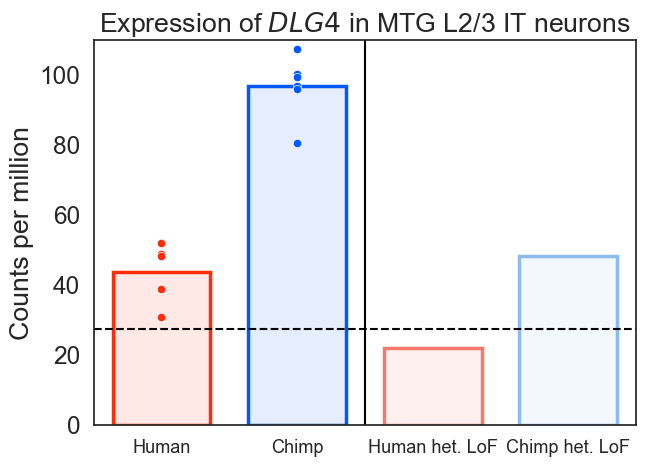

In [19]:
#To specifically make DLG4 plot

v = v[v["Species"].isin(["Human", "Chimp"])]

new_palette = {"Human":"#FF2C0C", "Chimp":"#0058FF", "Human het. LoF":"#F57A69", "Chimp het. LoF":"#8CBBF0"}
sns.set(font_scale = 1.6)
sns.set_style("white")
out = []
for i in ["L2-3_IT"]:
    for j in ["Human", "Chimp"]:
        vv = v[(v["Cell Type"].isin([i])) & (v["Species"].isin([j]))]
        if j == "Human" or j == "Chimp":
            vv_add = vv.copy()
            vv_add["CPM"] = vv_add["CPM"]/2
            vv_add["Species"] = [x + " het. LoF" for x in list(vv_add["Species"])]
            v = pd.concat([v, vv_add])
            out.append([str(i.replace("L2-3_IT", "L2/3 IT")), j + " het. LoF", np.mean(vv["CPM"]/2)])
        out.append([str(i.replace("L2-3_IT", "L2/3 IT")), j, np.mean(vv["CPM"])])
dfp = pd.DataFrame(out)
dfp.columns = ["Treatment", "Species", "Counts per million"]

fig, ax1 =  plt.subplots(figsize=(7,5))
ax1.set_ylabel('Counts per million')
ax1.set_xlabel('Cell type')
#ax2.set_ylabel('Proportion interaction')
#palette = {"Human":"#E31A1C", "Chimpanzee":"#1F78B4"}

#sns.swarmplot(data = v, x = "Type", y = "Signed proportion", hue = "Measurement", dodge = True, palette = palette, marker = "s")
t_ax = sns.barplot(data = dfp, x = "Species", y = "Counts per million", hue = "Species", dodge = False, errorbar=None, linewidth=2.5, edgecolor=".5", facecolor='#F2C91140', gap = 0.1, palette = new_palette, order = ["Human", "Chimp", "Human het. LoF", "Chimp het. LoF"])
for patch in t_ax.patches:
    print(patch.get_x() + patch.get_width()/2)
plt.xticks(None)
for i in np.unique(v["Cell Type"]):
    for j in ["Human", "Human het. LoF", "Chimp", "Chimp het. LoF"]:
        vv = v[(v["Cell Type"].isin([i])) & (v["Species"].isin([j]))]
        if j == "Human Het. LoF":
            x = np.repeat(2, vv.shape[0])
        elif j == "Human":
            x = np.repeat(0, vv.shape[0])
            sns.scatterplot(x = x, y = vv["CPM"], color = new_palette[j], marker = "o")
        elif j == "Chimp Het. LoF":
            x = np.repeat(3, vv.shape[0])
        elif j == "Chimp":
            x = np.repeat(1, vv.shape[0])
            sns.scatterplot(x = x, y = vv["CPM"], color = new_palette[j], marker = "o")
        
c = 0
for patch in t_ax.patches:
    if c == 0:
        patch.set_edgecolor(new_palette["Human het. LoF"])
        patch.set_facecolor(new_palette["Human het. LoF"] + "1A")
    elif c == 1:
        patch.set_edgecolor(new_palette["Human"])
        patch.set_facecolor(new_palette["Human"] + "1A")
    elif c == 2:
        patch.set_edgecolor(new_palette["Chimp het. LoF"])
        patch.set_facecolor(new_palette["Chimp het. LoF"] + "1A")
    elif c == 3:
        patch.set_edgecolor(new_palette["Chimp"])
        patch.set_facecolor(new_palette["Chimp"] + "1A")
    c += 1
plt.xticks(None)
plt.legend([],[], frameon=False)
plt.xticks(rotation=0, fontsize = 13)
plt.xlabel(None)
plt.hlines(y = 27.5, xmin = -0.5, xmax = 3.5, color = "black", linestyles = "dashed")
plt.xlim(-0.5, 3.5)
plt.vlines(x = 1.5, ymin = 0, ymax = 110, color = "black")
plt.ylim(0, 110)
plt.title("Expression of $\it{DLG4}$ in MTG L2/3 IT neurons")